# Anomaly detection with supervised classification

> Anomaly detection of data from **Lorenz attractor model**

Assignment from IBM's Coursera course **Applied AI with DeepLearning** as part of the [**Advanced Data Science Specialization**](https://www.coursera.org/specializations/advanced-data-science-ibm#courses).

Can construct a simple feed forward neural net, 3 dense layers, trained on healthy and broken samples.
If we were to run into a problem of unsupervised anomaly detection, best bet would be to use an autoencoder and train it with an LSTM on what we believe to be non-anonmalous data.


In [2]:
!pip install --upgrade keras-applications keras-preprocessing setuptools tensorflow==1.14.0 keras==2.2.5

    100% |################################| 51kB 1.7MB/s ta 0:00:011
    100% |################################| 51kB 2.4MB/s eta 0:00:01
    100% |################################| 593kB 1.7MB/s eta 0:00:01
    100% |################################| 109.2MB 229kB/s eta 0:00:01   63% |####################            | 69.5MB 50.8MB/s eta 0:00:01
    100% |################################| 337kB 4.8MB/s eta 0:00:01
    100% |################################| 20.2MB 1.1MB/s eta 0:00:01
    100% |################################| 2.9MB 3.3MB/s eta 0:00:01
    100% |################################| 491kB 4.7MB/s eta 0:00:01
    100% |################################| 3.2MB 3.2MB/s eta 0:00:01
    100% |################################| 112kB 5.8MB/s eta 0:00:01
    100% |################################| 61kB 596kB/s eta 0:00:01
    100% |################################| 2.7MB 3.2MB/s eta 0:00:01
    100% |################################| 1.3MB 3.9MB/s eta 0:00:01
    100% |###########

In [52]:
import tensorflow
if not tensorflow.__version__ == '1.14.0':
    print(tensorflow.__version__)
    raise ValueError('please upgrade to TensorFlow 1.14.0, or restart your Kernel (Kernel->Restart & Clear Output)')

import keras
if not keras.__version__ == '2.2.5':
    print(keras.__version__)
    raise ValueError('please upgrade to Keras 2.2.5, or restart your Kernel (Kernel->Restart & Clear Output)')

Import all dependencies 

In [2]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from queue import Queue
import pandas as pd
import json
%matplotlib inline

## Load data

Files for training are sampled from the lorenz attractor model implemented in NodeRED. https://developer.ibm.com/tutorials/iot-deep-learning-anomaly-detection-2/

In [3]:
#!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
!mv watsoniotp.healthy.phase_aligned.pickle watsoniotp.healthy.pickle
!mv watsoniotp.broken.phase_aligned.pickle watsoniotp.broken.pickle

rm: cannot remove 'watsoniotp.*': No such file or directory
--2020-03-05 15:00:50--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: 'watsoniotp.healthy.phase_aligned.pickle'

100%[======================================>] 194,639     --.-K/s   in 0.02s   

2020-03-05 15:00:51 (10.9 MB/s) - 'watsoniotp.healthy.phase_aligned.pickle' saved [194639/194639]

--2020-03-05 15:00:51--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubuserconte

In [4]:
data_healthy = pickle.load(open('watsoniotp.healthy.pickle', 'rb'), encoding='latin1')
data_broken = pickle.load(open('watsoniotp.broken.pickle', 'rb'), encoding='latin1')

In [12]:
data_healthy.shape

(3000, 3)

Three vibration sensor axes and 3000 samples

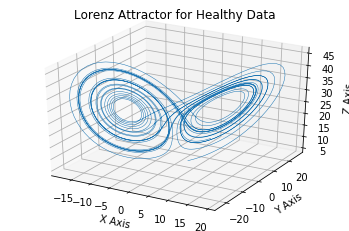

In [53]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(data_healthy[:,0], data_healthy[:,1], data_healthy[:,2],lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor for Healthy Data");

Then for the broken one

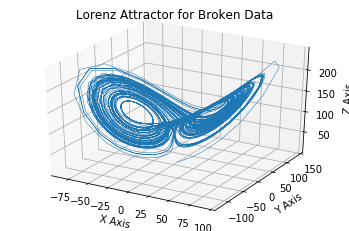

In [54]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(data_broken[:,0], data_broken[:,1], data_broken[:,2],lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor for Broken Data");

## Transform data

### Fast Fourier Transform

In [10]:
data_healthy_fft = np.fft.fft(data_healthy).real # sine decomposition
data_broken_fft = np.fft.fft(data_broken).real 

In [58]:
print (data_healthy_fft.shape)

(3000, 3)


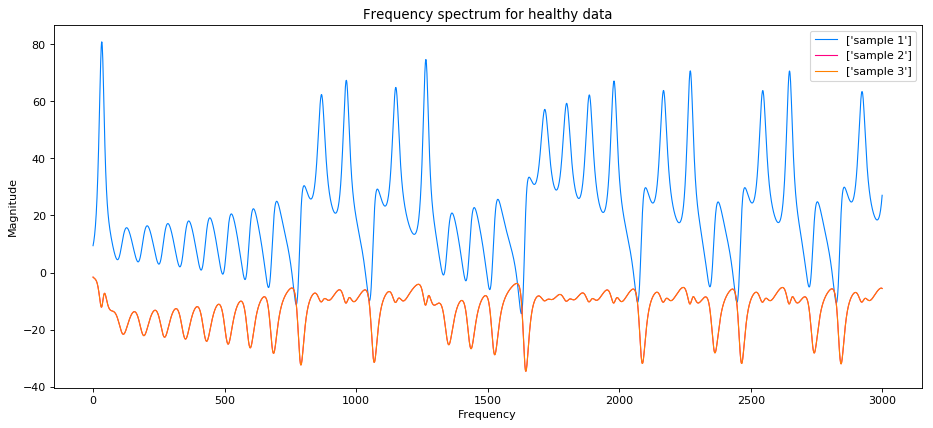

In [67]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color=(0,0.5,1), animated = True, linewidth=1, label=['sample 1'])
ax.plot(range(0,size), data_healthy_fft[:,1].real, '-', color=(1,0,0.5), animated = True, linewidth=1, label=['sample 2'])
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color=(1,0.5,0), animated = True, linewidth=1, label=['sample 3'])
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')
ax.set_title('Frequency spectrum for healthy data')
ax.legend()
None

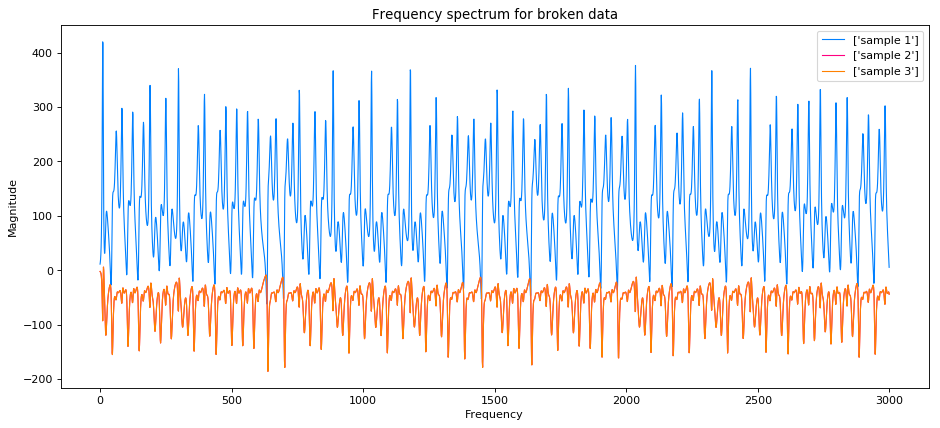

In [69]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color=(0,0.5,1), animated = True, linewidth=1, label=['sample 1'])
ax.plot(range(0,size), data_broken_fft[:,1].real, '-', color=(1,0,0.5), animated = True, linewidth=1, label=['sample 2'])
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color=(1,0.5,0), animated = True, linewidth=1, label=['sample 3'])
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')
ax.set_title('Frequency spectrum for broken data')
ax.legend()
None

In [18]:
def scaleData(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [19]:
data_healthy_scaled = scaleData(data_healthy_fft)
data_broken_scaled = scaleData(data_broken_fft)

In [20]:
data_healthy_scaled = data_healthy_scaled.T
data_broken_scaled = data_broken_scaled.T

Reshape to have three samples (rows, training example) and 3000 features (columns, features). 

In [21]:
data_healthy_scaled.reshape(3, 3000)
data_broken_scaled.reshape(3, 3000)

array([[0.15198831, 0.15926736, 0.1705979 , ..., 0.18128196, 0.15906354,
        0.13972883],
       [0.95790869, 0.95431429, 0.94972119, ..., 0.76231153, 0.75661709,
        0.73956562],
       [0.95790869, 0.95431429, 0.94972119, ..., 0.76231153, 0.75661709,
        0.73956562]])

## Model

In [81]:
dim = 3000
samples = 3

In [82]:
# callback to keep track of losses for keras

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr = LossHistory()

In [83]:
number_of_neurons_layer1 = 200
number_of_neurons_layer2 = 100
number_of_neurons_layer3 = 1
number_of_epochs = 2500

In [84]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)

model = Sequential()
model.add(Dense(number_of_neurons_layer1, input_shape=(dim, ), activation='relu'))
model.add(Dense(number_of_neurons_layer2, activation='relu'))
model.add(Dense(number_of_neurons_layer3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd)

def train(data,label): 
    model.fit(data, label, epochs=number_of_epochs, batch_size=72, validation_data=(data, label), verbose=False, shuffle=True,callbacks=[lr])
    
    # ideally, would split data for validation set, but since we only have three examples of each class limited options

def score(data):
    return model.predict(data)

In [85]:
# supervised, have to add labels (0-broken, 1-healthy) to training data before we train

label_healthy = np.repeat(1,3)
label_healthy.shape = (3,1)
label_broken = np.repeat(0,3)
label_broken.shape = (3,1)

train_healthy = np.hstack((data_healthy_scaled,label_healthy))
train_broken = np.hstack((data_broken_scaled,label_broken))
train_both = np.vstack((train_healthy,train_broken))

In [86]:
pd.DataFrame(train_healthy)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.250133,0.255146,0.260753,0.267016,0.274003,0.281791,0.290462,0.300109,0.310834,0.322747,...,0.369150,0.374541,0.380644,0.387513,0.395205,0.403782,0.413308,0.423850,0.435476,1.0
1,1.000000,0.997476,0.995146,0.992915,0.990694,0.988398,0.985940,0.983234,0.980193,0.976722,...,0.879227,0.880696,0.881835,0.882609,0.882982,0.882912,0.882356,0.881265,0.879589,1.0
2,1.000000,0.997476,0.995146,0.992915,0.990694,0.988398,0.985940,0.983234,0.980193,0.976722,...,0.879227,0.880696,0.881835,0.882609,0.882982,0.882912,0.882356,0.881265,0.879589,1.0


In [87]:
pd.DataFrame(train_broken)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.151988,0.159267,0.170598,0.188207,0.215687,0.25888,0.327175,0.434534,0.596514,0.810387,...,0.322272,0.295635,0.271778,0.249154,0.226781,0.204146,0.181282,0.159064,0.139729,0.0
1,0.957909,0.954314,0.949721,0.942610,0.930689,0.91001,0.873657,0.810554,0.708197,0.572845,...,0.752342,0.747264,0.747707,0.751641,0.756913,0.761310,0.762312,0.756617,0.739566,0.0
2,0.957909,0.954314,0.949721,0.942610,0.930689,0.91001,0.873657,0.810554,0.708197,0.572845,...,0.752342,0.747264,0.747707,0.751641,0.756913,0.761310,0.762312,0.756617,0.739566,0.0


In [88]:
pd.DataFrame(train_both)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.250133,0.255146,0.260753,0.267016,0.274003,0.281791,0.290462,0.300109,0.310834,0.322747,...,0.369150,0.374541,0.380644,0.387513,0.395205,0.403782,0.413308,0.423850,0.435476,1.0
1,1.000000,0.997476,0.995146,0.992915,0.990694,0.988398,0.985940,0.983234,0.980193,0.976722,...,0.879227,0.880696,0.881835,0.882609,0.882982,0.882912,0.882356,0.881265,0.879589,1.0
2,1.000000,0.997476,0.995146,0.992915,0.990694,0.988398,0.985940,0.983234,0.980193,0.976722,...,0.879227,0.880696,0.881835,0.882609,0.882982,0.882912,0.882356,0.881265,0.879589,1.0
3,0.151988,0.159267,0.170598,0.188207,0.215687,0.258880,0.327175,0.434534,0.596514,0.810387,...,0.322272,0.295635,0.271778,0.249154,0.226781,0.204146,0.181282,0.159064,0.139729,0.0
4,0.957909,0.954314,0.949721,0.942610,0.930689,0.910010,0.873657,0.810554,0.708197,0.572845,...,0.752342,0.747264,0.747707,0.751641,0.756913,0.761310,0.762312,0.756617,0.739566,0.0
5,0.957909,0.954314,0.949721,0.942610,0.930689,0.910010,0.873657,0.810554,0.708197,0.572845,...,0.752342,0.747264,0.747707,0.751641,0.756913,0.761310,0.762312,0.756617,0.739566,0.0


In [89]:
features = train_both[:,:3000] 
labels = train_both[:,3000:] 

In [90]:
train(features,labels)

0.93587106, 0.86942697, 0.8098089, 0.7579918, 0.7149565, 0.67997617, 0.64734507, 0.61954767, 0.5968929, 0.5778828, 0.55823463, 0.5417086, 0.5244531, 0.50633925, 0.49081874, 0.4778401, 0.46317664, 0.44722855, 0.43238947, 0.4184765, 0.40522215, 0.39252272, 0.37824214, 0.36863697, 0.35680017, 0.34587923, 0.33501053, 0.3214805, 0.3102293, 0.29824722, 0.28849244, 0.2778063, 0.26683423, 0.25856012, 0.25031146, 0.24161132, 0.23405285, 0.22538276, 0.21809168, 0.20987283, 0.20038693, 0.19253881, 0.18465556, 0.17916499, 0.17227978, 0.1656128, 0.15821129, 0.15285058, 0.14599611, 0.1392153, 0.13291791, 0.1281641, 0.12294116, 0.11774549, 0.11322237, 0.10828648, 0.103715956, 0.099522226, 0.09523854, 0.09193766, 0.08794858, 0.08492943, 0.081920475, 0.0791744, 0.07634782, 0.07385768, 0.071279265, 0.06900303, 0.066823535, 0.06478218, 0.06286776, 0.061018694, 0.059246942, 0.057692308, 0.055967424, 0.054383617, 0.052942995, 0.051594216, 0.050093863, 0.048801985, 0.047555417, 0.046379928, 0.04528472, 0.04

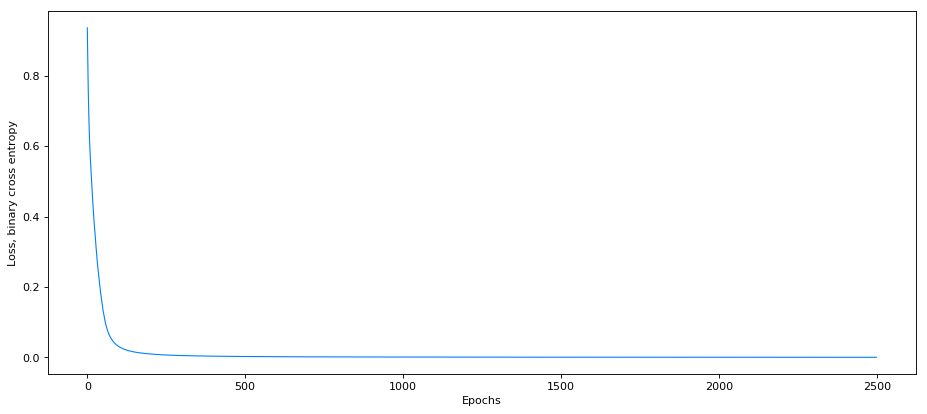

In [91]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(lr.losses)
ax.plot(range(0,size), lr.losses, '-', color=(0,0.5,1), animated = True, linewidth=1)
ax.set_ylabel('Loss, binary cross entropy')
ax.set_xlabel('Epochs');

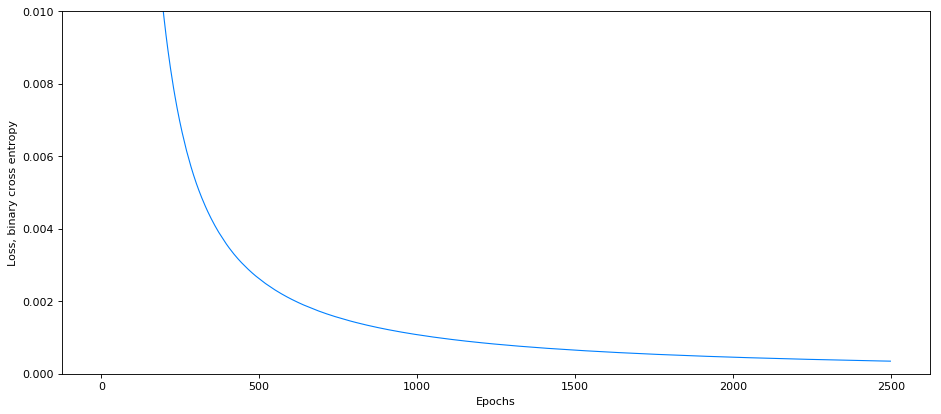

In [94]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(lr.losses)
ax.plot(range(0,size), lr.losses, '-', color=(0,0.5,1), animated = True, linewidth=1)
ax.set_ylabel('Loss, binary cross entropy')
ax.set_xlabel('Epochs')
ax.set_ylim(0,0.01);

In [95]:
# ideally would split for test data set as well

score(data_healthy_scaled)

array([[0.9994267 ],
       [0.99977916],
       [0.99977916]], dtype=float32)

In [96]:
score(data_broken_scaled)

array([[0.00066768],
       [0.00020282],
       [0.00020282]], dtype=float32)